# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer missing value encoded as 118
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [554]:
import pandas as pd
import numpy as np
import math
import json

%matplotlib inline

from sklearn.model_selection import train_test_split



# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration
- features and calculated statistics relevant to the problem have been reported and discussed
- Abnormalities or characteristics of the data or input that need to be addressed have been identified.
- A visualization has been provided that summarizes or extracts a relevant characteristic or feature about the dataset or input data with thorough discussion. Visual cues are clearly defined.

### 1. Portfolio data - containing offer ids and meta data about each offer (duration, type, etc.)

In [210]:
# Portfolio data: containing offer ids and meta data about each offer (duration, type, etc.)

print("length of dataset:", len(portfolio))
display(portfolio.head(10))


print("Missing values in portfolio data:")
display(portfolio.isna().sum())

display(portfolio.dtypes)

for column in portfolio.select_dtypes(include=['object']).columns:
    display(portfolio[column].value_counts())



length of dataset: 10


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


Missing values in portfolio data:


reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

reward         int64
channels      object
difficulty     int64
duration       int64
offer_type    object
id            object
dtype: object

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1653, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[web, email, mobile, social]    4
[web, email, mobile]            3
[email, mobile, social]         2
[web, email]                    1
Name: channels, dtype: int64

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

9b98b8c7a33c4b65b9aebfe6a799e6d9    1
2298d6c36e964ae4a3e7e9706d1fb8c2    1
fafdcd668e3743c1bb461111dcafc2a4    1
5a8bc65990b245e5a138643cd4eb9837    1
0b1e1539f2cc45b7b9fa7c272da2e1d7    1
ae264e3637204a6fb9bb56bc8210ddfd    1
2906b810c7d4411798c6938adc9daaa5    1
3f207df678b143eea3cee63160fa8bed    1
f19421c1d4aa40978ebb69ca19b0e20d    1
4d5c57ea9a6940dd891ad53e9dbe8da0    1
Name: id, dtype: int64

In [ ]:
## Recode some of the offer types?


### 2. Profile data - demographic data for each customer

In [377]:
print("length of dataset:", len(profile))
display(profile.head(10))


print("Missing values in portfolio data:")
display(profile.isna().sum()/len(profile))
print("Missing values in age column:", len(profile[profile['age']==118])/ len(profile))

display(profile.dtypes)

for column in profile.select_dtypes(include=['object']).columns:
    display(column, profile[column].value_counts())
    
for column in profile.select_dtypes(include=['int64']).columns:
    display(column, profile[column].describe())


## missing values in gender and income
## Became member should be date:

profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')

length of dataset: 17000


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,2016-11-22,NaN


Missing values in portfolio data:


gender              0.127941
age                 0.000000
id                  0.000000
became_member_on    0.000000
income              0.127941
dtype: float64

Missing values in age column: 0.12794117647058822


gender                      object
age                          int64
id                          object
became_member_on    datetime64[ns]
income                     float64
dtype: object

'gender'

M    8484
F    6129
O     212
Name: gender, dtype: int64

'id'

69addd8913974e6eae56b6e789acf2ca    1
cbdd0e50d9e24b60a9ff67444a2ff7ef    1
663c5a9d7fed499d97b23b514137fecd    1
d53717f5400c4e84affdaeda9dd926b3    1
597ebda5954741909a583df17c61c94b    1
                                   ..
79b6efb03873466e93714c376b1f1d1a    1
74aeed36262c4e8a833f5ee579b2fcd3    1
0ff34474e5b245b79f396d4c5ddef96c    1
cc35fd7b202a43d19eddbec7b76e01ca    1
3671e62b64104ba49147706fb33087ff    1
Name: id, Length: 17000, dtype: int64

'age'

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

### 3. Trancsript data - records for transactions, offers received, offers viewed, and offers completed

In [25]:
print("length of dataset:", len(transcript))
display(transcript.head(5))


print("Missing values in portfolio data:")
display(transcript.isna().sum())

display(transcript.dtypes)

for column in transcript.select_dtypes(include=['object']).columns:
    print(column)
    display(transcript[column].value_counts())

display(transcript.describe())

length of dataset: 306534


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


Missing values in portfolio data:


person    0
event     0
value     0
time      0
dtype: int64

person    object
event     object
value     object
time       int64
dtype: object

person


94de646f7b6041228ca7dec82adb97d2    51
8dbfa485249f409aa223a2130f40634a    49
79d9d4f86aca4bed9290350fb43817c2    48
5e60c6aa3b834e44b822ea43a3efea26    48
d0a80415b84c4df4908b8403b19765e3    48
                                    ..
e63e42480aae4ede9f07cac49c8c3f78     2
fccc9279ba56411f80ffe8ce7e0935cd     2
3a4e53046c544134bb1e7782248631d1     2
afd41b230f924f9ca8f5ed6249616114     2
da7a7c0dcfcb41a8acc7864a53cf60fb     1
Name: person, Length: 17000, dtype: int64

event


transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

value


TypeError: unhashable type: 'dict'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1653, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'dict'


{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}    14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}    14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}    14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}    14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}    14374
                                                    ...  
{'amount': 439.14}                                      1
{'amount': 42.75}                                       1
{'amount': 650.75}                                      1
{'amount': 943.4}                                       1
{'amount': 44.21}                                       1
Name: value, Length: 5121, dtype: int64

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


## Preprocess transcript data

In [555]:
# Turn json into dummy columns
transcript = transcript.join(pd.json_normalize(transcript['value'])).drop(columns = ['value'])

In [556]:
# Check missing values again

display(transcript.isna().sum()/len(transcript))

person      0.000000
event       0.000000
time        0.000000
offer id    0.562848
amount      0.546696
offer_id    0.890456
reward      0.890456
dtype: float64

In [557]:
transcript['offer id'] = transcript['offer id'].fillna(transcript.offer_id)
transcript.drop(columns = 'offer_id', inplace = True)
transcript = transcript.rename(columns={"offer id": "offer_id"})

In [558]:
transcript = transcript.reset_index()
transcript = transcript.join(pd.get_dummies(transcript['event']))

In [559]:
### Marking transactions that were bought with offer

# First sort the dataframe
transcript = transcript.sort_values(['person', 'index', 'time'])
transcript['offer_id_filled'] = np.where((transcript['offer completed']==1), transcript['offer_id'], np.nan)
transcript['offer_id_viewed'] = np.where((transcript['offer viewed']==1), transcript['offer_id'], np.nan)


transcript['offer_viewed_trans'] = transcript['offer viewed'].replace(to_replace=0, method='ffill', limit = 1)

# hard cut 20 transactions after offer
m1 = transcript['transaction']==1
transcript.loc[m1, 'offer_id_viewed'] = transcript['offer_id_viewed'].fillna(method='ffill', limit = 20)



# Make sure that offer was viewed before transaction so transaction qualifies
m2 = transcript['offer_viewed_trans'].isnull()==False
transcript.loc[m2, 'offer_id_filled'] = transcript['offer_id_filled'].fillna(method='bfill', limit = 1)

transcript['offer_id_final'] = np.where((transcript['offer_id_filled']==transcript['offer_id_viewed']), transcript['offer_id_filled'], np.nan)

# Also keep transactions after an informational offer without monetary reward
info_offers = portfolio[portfolio['offer_type']=='informational']['id'].unique()
transcript['offer_id_final'] = np.where(((transcript['offer_id_viewed'].isnull() == False) & (transcript['offer_id_viewed'].isin(info_offers))), transcript['offer_id_filled'], np.nan)

transcript['offer_id_final'].fillna(transcript['offer_id'], inplace = True)
transcript.drop(columns = 'offer_id', inplace = True)
transcript = transcript.rename(columns={'offer_id_final':'offer_id'})


In [560]:
# Check example
transcript[transcript['person'] == '0069a50874d846438e58acff5e594725'] 

,index,person,event,time,amount,reward,offer completed,offer received,offer viewed,transaction,offer_id_filled,offer_id_viewed,offer_viewed_trans,offer_id
52423,52423,0069a50874d846438e58acff5e594725,transaction,162,16.20,NaN,0,0,0,1,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,NaN
113176,113176,0069a50874d846438e58acff5e594725,offer received,336,NaN,NaN,0,1,0,0,NaN,NaN,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
147540,147540,0069a50874d846438e58acff5e594725,transaction,396,0.60,NaN,0,0,0,1,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN
152967,152967,0069a50874d846438e58acff5e594725,offer received,408,NaN,NaN,0,1,0,0,NaN,NaN,0,3f207df678b143eea3cee63160fa8bed
180415,180415,0069a50874d846438e58acff5e594725,transaction,438,3.61,NaN,0,0,0,1,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN
203928,203928,0069a50874d846438e58acff5e594725,offer received,504,NaN,NaN,0,1,0,0,NaN,NaN,0,2906b810c7d4411798c6938adc9daaa5
237730,237730,0069a50874d846438e58acff5e594725,offer viewed,552,NaN,NaN,0,0,1,0,NaN,2906b810c7d4411798c6938adc9daaa5,1,2906b810c7d4411798c6938adc9daaa5
247454,247454,0069a50874d846438e58acff5e594725,offer received,576,NaN,NaN,0,1,0,0,NaN,NaN,1,2906b810c7d4411798c6938adc9daaa5
279923,279923,0069a50874d846438e58acff5e594725,transaction,618,5.12,NaN,0,0,0,1,NaN,2906b810c7d4411798c6938adc9daaa5,0,NaN
302172,302172,0069a50874d846438e58acff5e594725,transaction,696,7.97,NaN,0,0,0,1,2906b810c7d4411798c6938adc9daaa5,2906b810c7d4411798c6938adc9daaa5,0,NaN


In [561]:
## Should reward be removed from order amount?


df_amount = transcript.groupby(['person', 'time','offer_id']).agg({'amount':'sum', 'reward':'sum', 'transaction':'sum'}).reset_index()
df_amount['order_value'] = df_amount['amount'] - df_amount['reward']
print("number of transactions with negative amount values:", len(df_amount[(df_amount['order_value']<0) & (df_amount['transaction']==1)]))

## As there are negative values I assume that amount already excludes reward
# transcript = transcript.merge(df_amount[['person','time','order_value']], on = ['person','time'], how = 'left')

number of transactions with negative amount values: 37


## Join portfolio dataframe

In [562]:
### Join portfolio dataframe

transcript = transcript.merge(portfolio, right_on = 'id', left_on = 'offer_id', how = 'left')


#### Check for non-qualifying discounts and remove

In [563]:
# There are some strange observations that should be excluded. 
# It seems some customers received discounts although they did not qualify with their order value

print("number of non-qualifying purchases:", len(transcript[((transcript['amount'] + transcript['reward_y']) < transcript['difficulty']) & (transcript['offer_id'].isnull()==False)])
)
print("percentage of non-qualifying purchases:",
      len(transcript[((transcript['amount'] + transcript['reward_y']) < transcript['difficulty'])
                     & (transcript['offer_id'].isnull()==False)]) / len(transcript['event'] == 'transaction') *100, "%")
display(transcript[((transcript['amount'] + transcript['reward_y']) < transcript['difficulty']) & (transcript['offer_id'].isnull()==False)].head())

# Observations will be excluded

number of non-qualifying purchases: 226
percentage of non-qualifying purchases: 0.07372754735200662 %


,index,person,event,time,amount,reward_x,offer completed,offer received,offer viewed,transaction,offer_id_filled,offer_id_viewed,offer_viewed_trans,offer_id,reward_y,channels,difficulty,duration,offer_type,id
99,144667,003d66b6608740288d6cc97a6903f4f0,transaction,384,3.66,NaN,0,0,0,1,fafdcd668e3743c1bb461111dcafc2a4,3f207df678b143eea3cee63160fa8bed,1,fafdcd668e3743c1bb461111dcafc2a4,2.0,"[web, email, mobile, social]",10.0,10.0,discount,fafdcd668e3743c1bb461111dcafc2a4
895,283939,00e52682848542c3a6f59b7824e9a5c5,transaction,624,7.32,NaN,0,0,0,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,5a8bc65990b245e5a138643cd4eb9837,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,"[web, email]",20.0,10.0,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
924,179059,00e9f403afa641889cd034ee7c7ca6e9,transaction,432,12.36,NaN,0,0,0,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,5a8bc65990b245e5a138643cd4eb9837,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,"[web, email]",20.0,10.0,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
1091,142787,01162252405b4524a8fa1bf8e6d5f04b,transaction,378,9.06,NaN,0,0,0,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,5a8bc65990b245e5a138643cd4eb9837,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,"[web, email]",20.0,10.0,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
1496,108915,016edb1d1d67477391c5337545a5d98a,transaction,318,14.94,NaN,0,0,0,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,3f207df678b143eea3cee63160fa8bed,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,"[web, email]",20.0,10.0,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [564]:
## Remove non-qualifying observations

transcript = transcript[~(((transcript['amount'] + transcript['reward_y']) < transcript['difficulty'])
                     & (transcript['offer_id'].isnull()==False))]

In [565]:
transcript.columns


Index(['index', 'person', 'event', 'time', 'amount', 'reward_x', 'offer completed', 'offer received', 'offer viewed', 'transaction', 'offer_id_filled', 'offer_id_viewed', 'offer_viewed_trans', 'offer_id', 'reward_y', 'channels', 'difficulty', 'duration', 'offer_type', 'id'], dtype='object')

In [566]:
#### Drop unnecessary columns
unnecess_cols = ['offer completed', 'offer received', 'offer viewed', 'transaction', 'offer_id_filled',
                 'offer_id_viewed', 'offer_viewed_trans','reward_x', 'id']
transcript = transcript.drop(columns = unnecess_cols)
transcript['offer_id'].fillna('no_special_offer', inplace = True)
transcript = transcript.rename(columns = {'reward_y':'potential_reward'})
                             

In [567]:
transcript['offer_id'].fillna('no_special_offer', inplace = True)
transcript.head()

,index,person,event,time,amount,offer_id,potential_reward,channels,difficulty,duration,offer_type
0,55972,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,3.0,informational
1,77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,3.0,informational
2,89291,0009655768c64bdeb2e877511632db8f,transaction,228,22.16,no_special_offer,NaN,NaN,NaN,NaN,NaN
3,113605,0009655768c64bdeb2e877511632db8f,offer received,336,NaN,3f207df678b143eea3cee63160fa8bed,0.0,"[web, email, mobile]",0.0,4.0,informational
4,139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,NaN,3f207df678b143eea3cee63160fa8bed,0.0,"[web, email, mobile]",0.0,4.0,informational


## Merge demographic information

In [568]:

transcript = transcript.merge(profile.rename(columns = {'id':'person'}), on = 'person', how = 'left')


In [569]:
transcript.offer_type.value_counts()

bogo             72398
discount         70701
informational    26066
Name: offer_type, dtype: int64

#### Limit data to transactions

In [638]:
df = transcript[transcript['event']=='transaction']

## Data Cleaning and Feature Generation

### Treat Missing values in merged data

In [606]:
print("Missing values in merged transcript data:")
display(df.isna().sum()/len(df))

print('Missing values in age column:', len(df[df['age']==118])/len(df))

# 10 % is quite a lot but they will have to be removed

df = df[df['age']!=118]

display(df.isna().sum()/len(df))


Missing values in merged transcript data:


index               0.000000
person              0.000000
event               0.000000
time                0.000000
amount              0.000000
offer_id            0.000000
potential_reward    0.988582
channels            0.988582
difficulty          0.988582
duration            0.988582
offer_type          0.988582
gender              0.107953
age                 0.000000
became_member_on    0.000000
income              0.107953
dtype: float64

Missing values in age column: 0.10795303005182841


index               0.000000
person              0.000000
event               0.000000
time                0.000000
amount              0.000000
offer_id            0.000000
potential_reward    0.987507
channels            0.987507
difficulty          0.987507
duration            0.987507
offer_type          0.987507
gender              0.000000
age                 0.000000
became_member_on    0.000000
income              0.000000
dtype: float64

### Generate new features

#### Ideas for pre-processing columns:

1. Put income into buckets
2. Calculate days since someone beacme member
3. Put age into buckets


In [607]:
### Age 
df.age.describe()

count    123751.000000
mean         52.717618
std          17.904179
min          18.000000
25%          39.000000
50%          54.000000
75%          65.000000
max         101.000000
Name: age, dtype: float64

In [639]:
# Important: Missing values are encoded as 118!
cut_labels_age = ['18-39', '40-54', '55-66', '67+']
cut_bins_age = [0, 40, 55, 67, 101]
df['age_bucket'] = pd.cut(df['age'], bins=cut_bins_age, labels=cut_labels_age)

/Users/mayrkah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [640]:
# Check
display(df[(df['age']>72) & (df['age']<118)])
display(df[df['age']==118])



,index,person,event,time,amount,offer_id,potential_reward,channels,difficulty,duration,offer_type,gender,age,became_member_on,income,age_bucket
415,21841,00a794f62b9a48beb58f8f6c02c2f1a6,transaction,18,6.03,no_special_offer,NaN,NaN,NaN,NaN,NaN,F,88,20151024,54000.0,67+
417,27464,00a794f62b9a48beb58f8f6c02c2f1a6,transaction,36,15.47,no_special_offer,NaN,NaN,NaN,NaN,NaN,F,88,20151024,54000.0,67+
418,32302,00a794f62b9a48beb58f8f6c02c2f1a6,transaction,54,15.88,no_special_offer,NaN,NaN,NaN,NaN,NaN,F,88,20151024,54000.0,67+
419,41748,00a794f62b9a48beb58f8f6c02c2f1a6,transaction,96,17.15,no_special_offer,NaN,NaN,NaN,NaN,NaN,F,88,20151024,54000.0,67+
422,76693,00a794f62b9a48beb58f8f6c02c2f1a6,transaction,186,26.39,no_special_offer,NaN,NaN,NaN,NaN,NaN,F,88,20151024,54000.0,67+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306082,238840,ffdefcac307f4ca99ac1ebd51470f106,transaction,552,13.43,no_special_offer,NaN,NaN,NaN,NaN,NaN,F,87,20170315,47000.0,67+
306085,301539,ffdefcac307f4ca99ac1ebd51470f106,transaction,690,10.78,no_special_offer,NaN,NaN,NaN,NaN,NaN,F,87,20170315,47000.0,67+
306089,86337,ffe5257abf8840b395e1ee6b29894637,transaction,216,34.95,no_special_offer,NaN,NaN,NaN,NaN,NaN,M,77,20170822,75000.0,67+
306094,140676,ffe5257abf8840b395e1ee6b29894637,transaction,372,15.22,no_special_offer,NaN,NaN,NaN,NaN,NaN,M,77,20170822,75000.0,67+


,index,person,event,time,amount,offer_id,potential_reward,channels,difficulty,duration,offer_type,gender,age,became_member_on,income,age_bucket
22,104088,00116118485d4dfda04fdbaba9a87b5c,transaction,294,0.70,no_special_offer,NaN,NaN,NaN,NaN,NaN,None,118,20180425,NaN,NaN
23,187632,00116118485d4dfda04fdbaba9a87b5c,transaction,456,0.20,no_special_offer,NaN,NaN,NaN,NaN,NaN,None,118,20180425,NaN,NaN
24,193680,00116118485d4dfda04fdbaba9a87b5c,transaction,474,3.19,no_special_offer,NaN,NaN,NaN,NaN,NaN,None,118,20180425,NaN,NaN
208,25759,0063def0f9c14bc4805322a488839b32,transaction,30,2.76,no_special_offer,NaN,NaN,NaN,NaN,NaN,None,118,20180615,NaN,NaN
211,90218,0063def0f9c14bc4805322a488839b32,transaction,228,2.06,no_special_offer,NaN,NaN,NaN,NaN,NaN,None,118,20180615,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306156,269577,ffede3b700ac41d6a266fa1ba74b4f16,transaction,594,0.72,no_special_offer,NaN,NaN,NaN,NaN,NaN,None,118,20180704,NaN,NaN
306157,272477,ffede3b700ac41d6a266fa1ba74b4f16,transaction,600,0.91,no_special_offer,NaN,NaN,NaN,NaN,NaN,None,118,20180704,NaN,NaN
306158,288311,ffede3b700ac41d6a266fa1ba74b4f16,transaction,642,2.32,no_special_offer,NaN,NaN,NaN,NaN,NaN,None,118,20180704,NaN,NaN
306159,293556,ffede3b700ac41d6a266fa1ba74b4f16,transaction,660,1.64,no_special_offer,NaN,NaN,NaN,NaN,NaN,None,118,20180704,NaN,NaN


In [610]:
### Age 
df.income.describe()

count    123751.000000
mean      61861.277889
std       20668.460051
min       30000.000000
25%       46000.000000
50%       60000.000000
75%       74000.000000
max      120000.000000
Name: income, dtype: float64

In [641]:

cut_labels_income = ['0-46000', '46001-60000', '60001-74000', '74001+']
cut_bins_income = [0, 46001, 60001, 74001, 120001]
df['income_bucket'] = pd.cut(df['income'], bins=cut_bins_income, labels=cut_labels_income)

/Users/mayrkah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [642]:
df['days_member'] = (pd.to_datetime('today').normalize() - pd.to_datetime(df.became_member_on, format = '%Y%m%d')).dt.days


/Users/mayrkah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [643]:
df['years_member'] = df.days_member/365

df['years_member'] = round(df['years_member'] - min(df['years_member']))

/Users/mayrkah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/mayrkah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [644]:
df.years_member.describe()

count    138727.000000
mean          1.737780
std           1.215052
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           5.000000
Name: years_member, dtype: float64

In [645]:
df = df.drop(columns = ['became_member_on', 'index'])

### Check dependent / label attribute amount

In [646]:
df.amount.describe()

count    138727.000000
mean         12.786287
std          30.273933
min           0.050000
25%           2.780000
50%           8.900000
75%          18.080000
max        1062.280000
Name: amount, dtype: float64

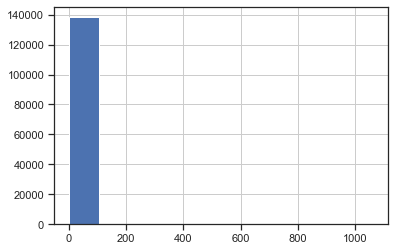

In [647]:
df.amount.hist()

In [652]:
# Anything above 50 seems a bit high
print(df.amount.quantile(.995))

df = df[df['amount']<=df.amount.quantile(.995)]

50.431099999999866


In [ ]:
## Outlier?

## Exploratory Visualization

- Analyze the problem through visualizations and data exploration to have a better understanding of what algorithms and features are appropriate for solving it.


In [617]:
df.dtypes

person                object
event                 object
time                   int64
amount               float64
offer_id              object
potential_reward     float64
channels              object
difficulty           float64
duration             float64
offer_type            object
gender                object
age                    int64
income               float64
age_bucket          category
income_bucket       category
days_member            int64
dtype: object

In [653]:
print("Missing values in portfolio data:")
display(df.isna().sum())


Missing values in portfolio data:


person                   0
event                    0
time                     0
amount                   0
offer_id                 0
potential_reward    136459
channels            136459
difficulty          136459
duration            136459
offer_type          136459
gender               14912
age                      0
income               14912
age_bucket           14912
income_bucket        14912
days_member              0
years_member             0
dtype: int64

In [654]:
### Filling NaN

df['offer_type'].fillna('no_offer_type', inplace = True)
df['duration'].fillna(0, inplace = True)
df['difficulty'].fillna(0, inplace = True)
df['potential_reward'].fillna(0, inplace = True)
df['channels'].fillna('no_channel', inplace = True)


In [636]:
df

,amount,potential_reward,difficulty,duration,age_bucket_18-39,age_bucket_40-54,age_bucket_55-66,age_bucket_67+,income_bucket_0-46000,income_bucket_46001-60000,...,offer_type_no_offer_type,offer_id_0b1e1539f2cc45b7b9fa7c272da2e1d7,offer_id_2298d6c36e964ae4a3e7e9706d1fb8c2,offer_id_2906b810c7d4411798c6938adc9daaa5,offer_id_4d5c57ea9a6940dd891ad53e9dbe8da0,offer_id_9b98b8c7a33c4b65b9aebfe6a799e6d9,offer_id_ae264e3637204a6fb9bb56bc8210ddfd,offer_id_f19421c1d4aa40978ebb69ca19b0e20d,offer_id_fafdcd668e3743c1bb461111dcafc2a4,offer_id_no_special_offer
2,0.256596,-0.098938,-0.099987,-0.109987,1.644556,-0.611271,-0.572713,-0.517228,-0.597751,-0.582666,...,0.112476,-0.04553,-0.032428,-0.046761,-0.025907,-0.054984,-0.038588,-0.031025,-0.032553,0.112476
6,-0.171109,7.953980,3.978281,5.767455,1.644556,-0.611271,-0.572713,-0.517228,-0.597751,-0.582666,...,-8.890778,-0.04553,-0.032428,-0.046761,-0.025907,-0.054984,-0.038588,32.232350,-0.032553,-8.890778
10,0.003246,-0.098938,-0.099987,-0.109987,1.644556,-0.611271,-0.572713,-0.517228,-0.597751,-0.582666,...,0.112476,-0.04553,-0.032428,-0.046761,-0.025907,-0.054984,-0.038588,-0.031025,-0.032553,0.112476
13,-0.014064,-0.098938,-0.099987,-0.109987,1.644556,-0.611271,-0.572713,-0.517228,-0.597751,-0.582666,...,0.112476,-0.04553,-0.032428,-0.046761,-0.025907,-0.054984,-0.038588,-0.031025,-0.032553,0.112476
15,-0.117607,-0.098938,-0.099987,-0.109987,1.644556,-0.611271,-0.572713,-0.517228,-0.597751,-0.582666,...,0.112476,-0.04553,-0.032428,-0.046761,-0.025907,-0.054984,-0.038588,-0.031025,-0.032553,0.112476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306297,-0.026338,-0.098938,-0.099987,-0.109987,-0.608067,1.635935,-0.572713,-0.517228,-0.597751,-0.582666,...,0.112476,-0.04553,-0.032428,-0.046761,-0.025907,-0.054984,-0.038588,-0.031025,-0.032553,0.112476
306299,-0.195657,-0.098938,-0.099987,-0.109987,-0.608067,1.635935,-0.572713,-0.517228,-0.597751,-0.582666,...,0.112476,-0.04553,-0.032428,-0.046761,-0.025907,-0.054984,-0.038588,-0.031025,-0.032553,0.112476
306303,0.007023,-0.098938,-0.099987,-0.109987,-0.608067,1.635935,-0.572713,-0.517228,-0.597751,-0.582666,...,0.112476,-0.04553,-0.032428,-0.046761,-0.025907,-0.054984,-0.038588,-0.031025,-0.032553,0.112476
306306,-0.122327,-0.098938,-0.099987,-0.109987,-0.608067,1.635935,-0.572713,-0.517228,-0.597751,-0.582666,...,0.112476,-0.04553,-0.032428,-0.046761,-0.025907,-0.054984,-0.038588,-0.031025,-0.032553,0.112476


In [655]:
df.loc[:, "channels"] = df["channels"].astype("str")
df.loc[:, "channels"] = df["channels"].astype("category")
df.loc[:, "gender"] = df["gender"].astype("category")
df.loc[:, "offer_type"] = df["offer_type"].astype("category")


In [622]:
df["channels"].unique()

[no_channel, ['web', 'email', 'mobile', 'social'], ['web', 'email'], ['email', 'mobile', 'social'], ['web', 'email', 'mobile']]
Categories (5, object): [no_channel, ['web', 'email', 'mobile', 'social'], ['web', 'email'], ['email', 'mobile', 'social'], ['web', 'email', 'mobile']]

In [656]:
channel_old = ["no_channel", "['web', 'email', 'mobile', 'social']", "['web', 'email', 'mobile']", "['web', 'email']", "['email', 'mobile', 'social']"]
channel_new = ["no_channel", "all_channels", "no_social", "no_web_social", "no_web"]

df['channels'] = df['channels'].replace(channel_old, channel_new)


In [657]:
df.loc[:, "channels"] = df["channels"].astype("category")

In [658]:

for column in df.select_dtypes(include=['category']).columns:
    display(column, df[column].value_counts())

'channels'

no_channel       136459
no_social           657
all_channels        480
no_web_social       254
no_web              183
Name: channels, dtype: int64

'offer_type'

no_offer_type    136459
discount            797
bogo                777
Name: offer_type, dtype: int64

'gender'

M    72277
F    49075
O     1769
Name: gender, dtype: int64

'age_bucket'

40-54    33508
18-39    33232
55-66    30394
67+      25987
Name: age_bucket, dtype: int64

'income_bucket'

0-46000        32414
46001-60000    31218
60001-74000    30642
74001+         28847
Name: income_bucket, dtype: int64

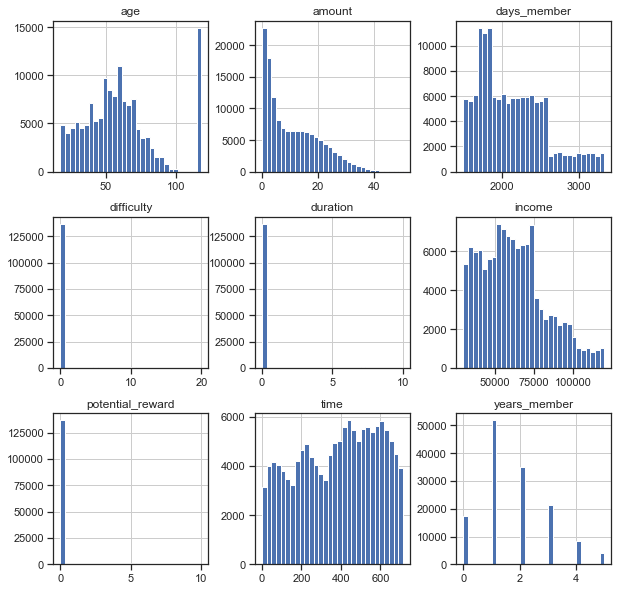

In [659]:
# build histograms for each numeric feature
%matplotlib inline
hist = df.hist(bins=30, sharey=False, figsize=(10, 10))

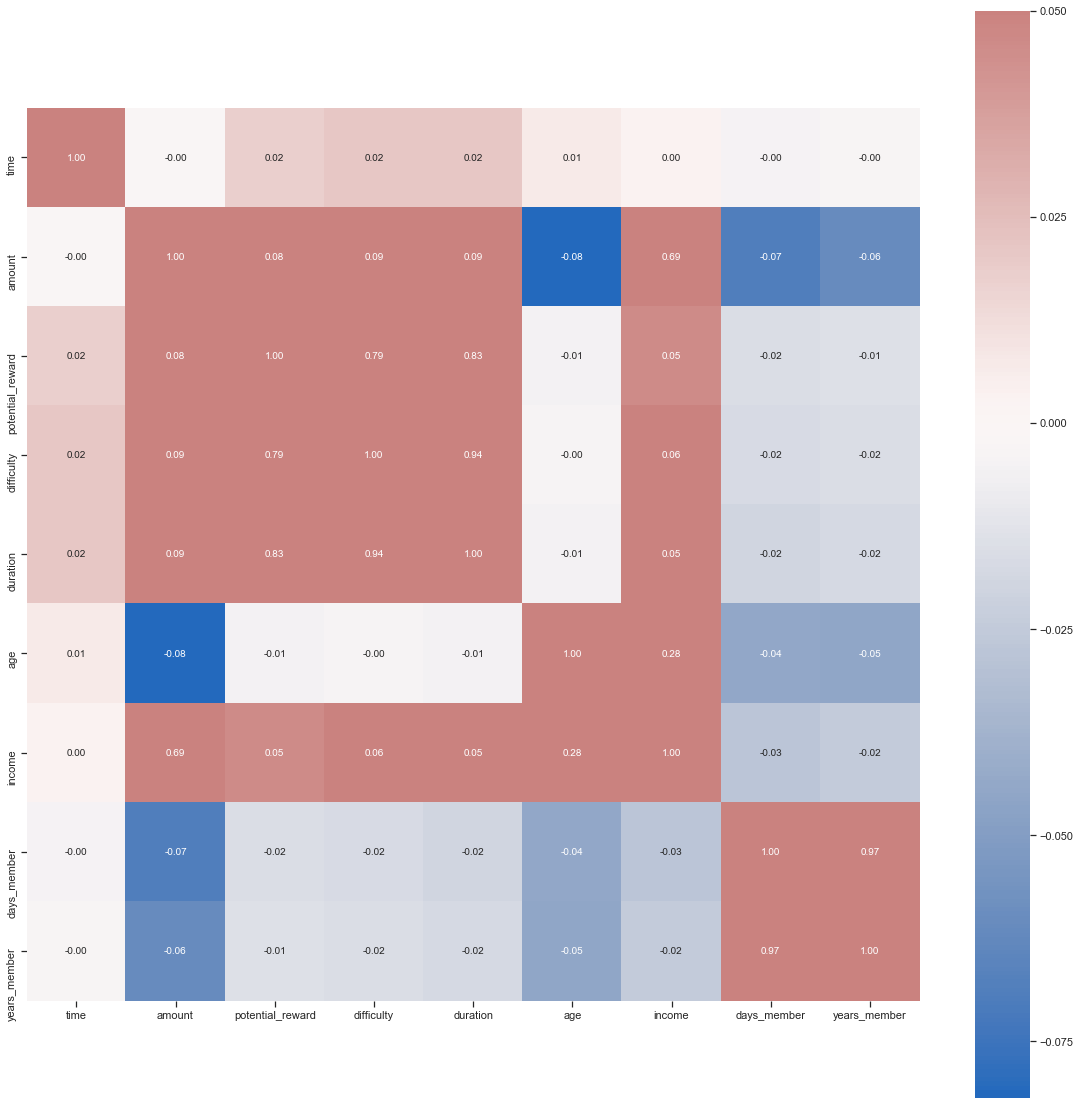

In [662]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=[20,20])
sns.heatmap(df.corr(), annot=True, fmt='.2f',square=True, cmap='vlag', center=0, vmax=0.05)

## Amount most strongely correlates with income

In [660]:
corr = df.corr()

In [661]:
corr

,time,amount,potential_reward,difficulty,duration,age,income,days_member,years_member
time,1.000000,-0.002319,0.018049,0.021526,0.021654,0.006957,0.003274,-0.004864,-0.003354
amount,-0.002319,1.000000,0.079619,0.093576,0.089432,-0.081869,0.686878,-0.069112,-0.061020
potential_reward,0.018049,0.079619,1.000000,0.790187,0.831183,-0.005471,0.046378,-0.015743,-0.014401
difficulty,0.021526,0.093576,0.790187,1.000000,0.938421,-0.004366,0.055029,-0.016864,-0.015550
duration,0.021654,0.089432,0.831183,0.938421,1.000000,-0.005625,0.049838,-0.019503,-0.017756
age,0.006957,-0.081869,-0.005471,-0.004366,-0.005625,1.000000,0.282693,-0.044668,-0.045232
income,0.003274,0.686878,0.046378,0.055029,0.049838,0.282693,1.000000,-0.027806,-0.024614
days_member,-0.004864,-0.069112,-0.015743,-0.016864,-0.019503,-0.044668,-0.027806,1.000000,0.971353
years_member,-0.003354,-0.061020,-0.014401,-0.015550,-0.017756,-0.045232,-0.024614,0.971353,1.000000


# Definition

## Project overview

will build a machine learning model that predicts how much someone will spend based on demographics and offer type

## Project Statement
Starbucks wants blabka

Ex: 
The problem with restaurants and food-related businesses is not knowing future demand for your services. Because this is an unknown, you may create or purchase too much or too little of an item. Furthermore, there are also operational costs associated with not knowing demand as it may require additional personal and equipment. This leads to a mismatch in demand between the business and the customer, leading to a poor experience.

## Objective

Predict demand based on the restaurant's risk tolerance, and create "what if" scenarios to better prepare the business. This creates new tools for the restaurants to better serve their customer and overall create an improved experience.

# Analysis

In [663]:
df.columns


Index(['person', 'event', 'time', 'amount', 'offer_id', 'potential_reward', 'channels', 'difficulty', 'duration', 'offer_type', 'gender', 'age', 'income', 'age_bucket', 'income_bucket', 'days_member', 'years_member'], dtype='object')

In [664]:
### Creating new features 

age_bucket_one_hot_df = pd.get_dummies(df.age_bucket, prefix="age_bucket")
df[age_bucket_one_hot_df.columns.tolist()] = age_bucket_one_hot_df

In [665]:
income_bucket_one_hot_df = pd.get_dummies(df.income_bucket, prefix="income_bucket")
df[income_bucket_one_hot_df.columns.tolist()] = income_bucket_one_hot_df

In [666]:
channels_one_hot_df = pd.get_dummies(df.channels, prefix="channel")
df[channels_one_hot_df.columns.tolist()] = channels_one_hot_df

In [667]:
gender_one_hot_df = pd.get_dummies(df.gender, prefix="gender")
df[gender_one_hot_df.columns.tolist()] = gender_one_hot_df

In [668]:
offer_type_one_hot_df = pd.get_dummies(df.offer_type, prefix="offer_type")
df[offer_type_one_hot_df.columns.tolist()] = offer_type_one_hot_df

In [669]:
offer_id_one_hot_df = pd.get_dummies(df.offer_id, prefix="offer_id")
df[offer_id_one_hot_df.columns.tolist()] = offer_id_one_hot_df

In [670]:
df = df.drop(columns = ['time', 'days_member', 'person', 'event','age', 'income', 'income_bucket', 'age_bucket', 'channels', 'offer_type', 'gender', 'offer_id'])

In [671]:
# Standarize feature values to have a zero mean
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df[df.columns])
df.loc[:, df.columns] = scaler.transform(df[df.columns])

In [672]:
df.columns

Index(['amount', 'potential_reward', 'difficulty', 'duration', 'years_member', 'age_bucket_18-39', 'age_bucket_40-54', 'age_bucket_55-66', 'age_bucket_67+', 'income_bucket_0-46000', 'income_bucket_46001-60000', 'income_bucket_60001-74000', 'income_bucket_74001+', 'channel_all_channels', 'channel_no_channel', 'channel_no_social', 'channel_no_web', 'channel_no_web_social', 'gender_F', 'gender_M', 'gender_O', 'offer_type_bogo', 'offer_type_discount', 'offer_type_no_offer_type', 'offer_id_0b1e1539f2cc45b7b9fa7c272da2e1d7', 'offer_id_2298d6c36e964ae4a3e7e9706d1fb8c2', 'offer_id_2906b810c7d4411798c6938adc9daaa5', 'offer_id_4d5c57ea9a6940dd891ad53e9dbe8da0', 'offer_id_9b98b8c7a33c4b65b9aebfe6a799e6d9', 'offer_id_ae264e3637204a6fb9bb56bc8210ddfd', 'offer_id_f19421c1d4aa40978ebb69ca19b0e20d', 'offer_id_fafdcd668e3743c1bb461111dcafc2a4', 'offer_id_no_special_offer'], dtype='object')

In [ ]:
## Scatterplots

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
df.plot(ax=axes[0, 0], x="sepal length (cm)", y="sepal width (cm)", kind="scatter")
df.plot(ax=axes[0, 1], x="sepal length (cm)", y="petal length (cm)", kind="scatter")
df.plot(ax=axes[0, 2], x="sepal length (cm)", y="petal width (cm)", kind="scatter")
df.plot(ax=axes[1, 0], x="sepal width (cm)", y="petal length (cm)", kind="scatter")
df.plot(ax=axes[1, 1], x="sepal width (cm)", y="petal width (cm)", kind="scatter")
df.plot(ax=axes[1, 2], x="petal length (cm)", y="petal width (cm)", kind="scatter")

In [ ]:
### Splitting train and test datasets

In [673]:
df = df.rename(columns={"amount": "target"})


In [674]:
# train: 0.8 | test: 0.2
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)

## train: 0.6 | validation: 0.2
#df_train, df_val = train_test_split(df_train, test_size=0.25, random_state=0)
#
## Final dataset sizes: train: 0.6, validation: 0.2, text: 0.2,

In [675]:
print(f"Train: {df_train.shape}")
#print(f"Validation: {df_val.shape}")
print(f"Test: {df_test.shape}")

Train: (110426, 33)
Test: (27607, 33)


# Save all clean data, and the train, validation, test data as csv
df.to_csv("data_clean.csv", index=False)
df_train.to_csv("train.csv", index=False)
df_val.to_csv("validation.csv", index=False)
df_test.to_csv("test.csv", index=False)

In [ ]:
# Baseline: Linear regression?

In [679]:
import pandas as pd
from sklearn.linear_model import LinearRegression


# regression model
reg = LinearRegression().fit(df[[col for col in df.columns if col !='target']], df["target"])
reg.score(df[[col for col in df.columns if col !='target']], df["target"])

0.5546256993593426

In [681]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.metrics import r2_score, accuracy_score
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [434]:
### Using XGBoost

!pip install xgboost

Looking in indexes: https://tools.adidas-group.com/artifactory/api/pypi/pypi-trading-sciences/simple


In [682]:
# Load your train/test dataframe into DMatrix
dtrain = xgb.DMatrix(
    df_train.loc[:, df_train.columns != "target"], label=df_train["target"]
)
dtest = xgb.DMatrix(
    df_test.loc[:, df_test.columns != "target"], label=df_test["target"]
)

In [700]:
# How does the model perform on the training dataset and default model parameters?
# Using the hyperparameters in the requirements, is there improvement?
# Remember we use the test dataset to score the model
param = {
    "max_depth": 20,
    "eta": 0.03,
    "gamma": 0.09,
    "colsample_bytree": 0.5,
    "objective": "reg:squarederror",
}
num_round = 100
bst = xgb.train(param, dtrain, num_round)

In [701]:
# xgboost is not scikit learn, so you'll need to do predictions using their API
preds = bst.predict(dtest)

In [702]:
len(preds)

27607

In [703]:
df_test["target"]

116235    0.788487
281783   -0.539785
225425    0.729244
242114    1.026495
173879   -1.041784
            ...   
228677   -0.302816
248542   -0.882766
304949    2.196787
262450    0.551518
161498   -1.121813
Name: target, Length: 27607, dtype: float64

In [704]:
# R2 score using scikit learn function for regression metric
r2_score(df_test["target"], preds)

0.5718712267728892

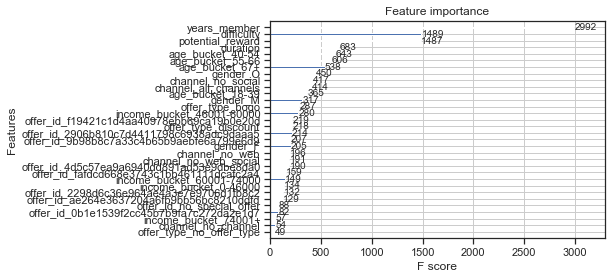

In [705]:
# Plot the importance of the features based on fitted trees
xgb.plot_importance(bst)

In [ ]:
import os
import boto3
import sagemaker

sess = sagemaker.Session()

bucket = sess.default_bucket()
print(bucket)
prefix = 'bootcamp-xgboost-churn'

boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(
    prefix, 'validation/validation.csv')).upload_file('validation.csv')

In [ ]:
# Set the IAM Role
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
# Get the XGBoost docker image
from sagemaker import image_uris
container = image_uris.retrieve('xgboost', boto3.Session().region_name, '1.0-1')
display(container)

In [ ]:
# Creating the SageMaker Estimator object
import sagemaker
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    sagemaker_session =sess,
    instance_count =1,
    instance_type="ml.m4.xlarge",
    max_run=2000,
    max_wait = 2500,
    use_spot_instances=True #Save up to 90%
)

In [ ]:
# Set the hyperparameters
xgb.set_hyperparameters(
    objective="binary:logistic",
    num_round=1000,
    max_depth=100,
    subsample=0.8,
    eta=0.1,
    gamma=1
)

In [ ]:
# Configuring the data inputs
s3_input_train = sagemaker.inputs.TrainingInput(
    s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(
    s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

In [ ]:
# Training the model
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

In [ ]:
# Recreate the Estimator from above
# Creating the SageMaker Estimator object
xgb = sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    sagemaker_session =sess,
    instance_count =1,
    instance_type="ml.m4.xlarge",
    max_run=2000,
    max_wait = 2500,
    use_spot_instances=True #Save up to 90%
)


### From my nlp project

In [ ]:
training_path= "s3://{}/{}/".format(bucket, "data/dogImages")
s3_output_dir = "s3://{}/{}/".format(bucket, "output")
s3_model_dir = "s3://{}/{}/".format(bucket, "model")
os.environ['SM_CHANNEL_TRAIN']=training_path
os.environ['SM_MODEL_DIR']=s3_model_dir
os.environ['SM_OUTPUT_DATA_DIR']=s3_output_dir


In [ ]:
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256]),
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [ ]:
#TODO: Create estimators for your HPs
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    role=sagemaker.get_execution_role(),
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [ ]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

In [ ]:

hyperparameters = {"lr": '0.0010890341083269243',
                  "batch-size": 256}

estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py36",
    profiler_config=profiler_config,
    hyperparameters=hyperparameters,
    debugger_hook_config=debugger_config,
    rules=rules,
)

#os.environ['SM_CHANNEL_TRAIN']=training_path
#os.environ['SM_MODEL_DIR']=s3_model_dir
#os.environ['SM_OUTPUT_DATA_DIR']=s3_output_dir
estimator.fit({"train": training_path}, wait=True)

In [ ]:
# TODO: Plot a debutraining_job_name = estimator.latest_training_job.name
session = boto3.session.Session()
region = session.region_name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor("NLLLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("NLLLoss_output_0").steps(mode=ModeKeys.EVAL)))


In [ ]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium") # TODO: Add your deployment configuration like instance type and number of instances

In [ ]:
predictor = sagemaker.predictor.Predictor('pytorch-training-2022-08-09-14-18-19-119', sagemaker_session=sagemaker_session)


In [ ]:
response = predictor.predict(data = img_tensor_pred)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

#### end

In [ ]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter

xgb.set_hyperparameters(objective='binary:logistic',
                        num_round=1500)
hyperparameter_ranges = { 
   "max_depth": IntegerParameter(10, 2000),
    "eta":ContinuousParameter(0,1),
    "gamma":IntegerParameter(4,20),
    "subsample":ContinuousParameter(0,1)
}

In [ ]:
# Compete the statement
objective_metric_name = "validation:auc"

In [ ]:
# Bar plot of all scores from each model fit: all_df_score, val_df_score, val_df_h_score, test_df_h_score
pd.Series(
    {
        "all_df_score": all_df_score,
        "val_df_score": val_df_score,
        "val_df_h_score": val_df_h_score,
        "test_df_h_score": test_df_h_score,
    }
).plot(kind="bar", legend=False, title="R2 Score of Ridge Model")